# Lipstick on a Pig: Debiasing Methods Cover up Systematic Gender Biases  in Word Embeddings But do not Remove Them

For a detailed explanation of the experiments in this notebook, see:
[paper](https://arxiv.org/pdf/1903.03862.pdf "Lipstick on a Pig paper")

## Preprocessing

### Load embeddings

In [1]:
!python --version

Python 3.9.12


In [2]:
import codecs
import numpy as np
from numpy import linalg as LA

def load_embeddings_from_np(filename):
    print('loading ...')
    with codecs.open(filename + '.vocab', 'r', 'utf-8') as f_embed:
        vocab = [line.strip() for line in f_embed]
        
    w2i = {w: i for i, w in enumerate(vocab)}
    wv = np.load(filename + '.wv.npy')

    return vocab, wv, w2i

def load_dhdglove(path):
    print('loading ...')
    debiased_embeds = pickle.load(open(path, 'rb'))
    wv = []
    vocab = []
    for w in debiased_embeds:
        wv.append(np.array(debiased_embeds[w]))
        vocab.append(str(w))
        
    w2i = {w: i for i, w in enumerate(vocab)}
    wv = np.array(wv).astype(float)
    print(len(vocab), wv.shape, len(w2i))
        
    return vocab, wv, w2i 

def normalize(wv): 

    norms = np.apply_along_axis(LA.norm, 1, wv) 
    wv = wv / norms[:, np.newaxis]
    return wv


def load_and_normalize(space, filename, vocab, wv, w2i): 
    vocab_muse, wv_muse, w2i_muse = load_embeddings_from_np(filename)
    wv_muse = normalize(wv_muse)
    vocab[space] = vocab_muse 
    wv[space] = wv_muse
    w2i[space] = w2i_muse
    print('done')
    

def load_wo_normalize(space, filename, vocab, wv, w2i):
    if filename[-3:]=='txt':
        vocab_muse, wv_muse, w2i_muse = load_embeddings_from_np(filename)
    else:
        vocab_muse, wv_muse, w2i_muse = load_dhdglove(filename)
    vocab[space] = vocab_muse 
    wv[space] = wv_muse
    w2i[space] = w2i_muse
    print('done')
    


In [3]:
vocab = {}
wv = {}
w2i = {}

#uploading the original GloVe
load_and_normalize('bef', './data/embeddings/glove_wiki_vectors.txt', vocab, wv, w2i)
#uploading the debiased GloVe (change the path with the desidered debiased method)
load_wo_normalize('aft', './data/embeddings/vectors_hd.txt', vocab, wv, w2i)


loading ...
done
loading ...
done


In [4]:
for v in wv['aft']:
    assert(len(v) == 300)
wv['aft'] = wv['aft'][:,:-1]


for v in wv['aft']:
    assert(len(v) == 299)
    
wv['aft'] = normalize(wv['aft'])

In [5]:
from tqdm import tqdm

def topK(w, space, k=10):
    
    idx = w2i[space][w]
    vec = wv[space][idx, :]

    sim = wv[space].dot(vec)
    sort_sim = (sim.argsort())[::-1]

    best = sort_sim[:(k+1)]

    return [vocab[space][i] for i in best if i!=idx]


def similarity(w1, w2, space):
    
    i1 = w2i[space][w1]
    i2 = w2i[space][w2]
    vec1 = wv[space][i1, :]
    vec2 = wv[space][i2, :]

    return np.inner(vec1,vec2)



### Restrict vocabulary

In [6]:
import string 


def has_punct(w): 
    
    if any([c in string.punctuation for c in w]):
        return True
    return False

def has_digit(w): 
    
    if any([c in '0123456789' for c in w]):
        return True
    return False

def limit_vocab(space, exclude = None, vec_len = 300):
    vocab_limited = []
    for w in tqdm(vocab[space][:50000]): 
        if w.lower() != w: 
            continue
        if len(w) >= 20: 
            continue
        if has_digit(w): 
            continue
        if '_' in w:
            p = [has_punct(subw) for subw in w.split('_')]
            if not any(p):
                vocab_limited.append(w)
            continue
        if has_punct(w):
            continue
        vocab_limited.append(w)
    
    if exclude:
        vocab_limited = list(set(vocab_limited) - set(exclude))
    
    print("size of vocabulary:", len(vocab_limited))
    
    wv_limited = np.zeros((len(vocab_limited), vec_len))
    for i,w in enumerate(vocab_limited):
        wv_limited[i,:] = wv[space][w2i[space][w],:]
    
    w2i_limited = {w: i for i, w in enumerate(vocab_limited)}
    
    return vocab_limited, wv_limited, w2i_limited


In [7]:
gender_specific = []
with open('./data/lists/male_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
with open('./data/lists/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

        
exclude_words = gender_specific

vocab['limit_bef'], wv['limit_bef'], w2i['limit_bef'] = limit_vocab('bef', exclude = exclude_words)
vocab['limit_aft'], wv['limit_aft'], w2i['limit_aft'] = limit_vocab('aft', exclude = exclude_words, vec_len = 299)

assert(vocab['limit_aft'] == vocab['limit_bef'])


100%|████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 526450.39it/s]


size of vocabulary: 47698


100%|████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 486970.25it/s]


size of vocabulary: 47698


### Compute bias-by-projection
The bias by projection is the measure of bias proposed by [Bolukbasi et al](https://arxiv.org/abs/1607.06520)

In [8]:
def compute_bias_by_projection(space_to_tag, full_space):
    males = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['he'],:])
    females = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['she'],:])
    d = {}
    for w,m,f in zip(vocab[space_to_tag], males, females):
        d[w] = m-f
    return d


gender_bias_bef = compute_bias_by_projection('limit_bef', 'bef')
gender_bias_aft = compute_bias_by_projection('limit_aft', 'aft')

### Compute the average direct bias

In [16]:
def report_bias(gender_bias):
    bias = 0.0
    for k in gender_bias:
        bias += np.abs(gender_bias[k])
    print(bias/len(gender_bias))

print('mean bef: ')
report_bias(gender_bias_bef)
print('meas aft: ')
report_bias(gender_bias_aft)

print('sd bef: ', np.std(list(gender_bias_bef.values())))
print('sd aft: ', np.std(list(gender_bias_aft.values())))

mean bef: 
0.03754117927459324
meas aft: 
0.0008188003946149476
sd bef:  0.04825411838917043
sd aft:  0.004480993996421994


In [17]:
def summary_direct(bias):
    print('avg: ', np.mean(bias), 'sd: ', np.std(bias))
    

def gen_bias(gender_bias):
    male = []
    female = []
    for word in gender_bias:
        if gender_bias[word]>0:
            male.append(gender_bias[word])
        else:
            female.append(gender_bias[word])
    return male, female    
male_bef, female_bef = gen_bias(gender_bias_bef)
male_aft, female_aft = gen_bias(gender_bias_aft)

In [23]:
#compute male and female average bias
summary_direct(male_bef)
summary_direct(male_aft)
summary_direct(female_bef)
summary_direct(female_aft)

avg:  0.037316036453887994 sd:  0.02744163010824527
avg:  0.0007658084445492418 sd:  0.0018776919336297004
avg:  -0.03784405603604986 sd:  0.03474871951815855
avg:  -0.0008800300557487574 sd:  0.00614443691752682


In [12]:
import pandas as pd
pd.DataFrame(list(gender_bias_bef.values())).to_csv('bias_bef.csv')
pd.DataFrame(list(gender_bias_aft.values())).to_csv('bias_HD.csv')

## Experiments

### Coreelation between bias-by-projection and bias-by-neighbors

In [24]:
def bias_by_neighbors(space, neighbours_num = 100):
    
    tuples = []
    for w in tqdm(vocab[space]):
        
        top = topK(w, space, k=neighbours_num+5)[:neighbours_num]

        m = 0
        f = 0    
        for t in top:
            if gender_bias_bef[t] > 0:
                m+=1
            else:
                f+=1
        tuples.append((w, gender_bias_bef[w], gender_bias_aft[w], m, f))

    return tuples
        
tuples_bef = bias_by_neighbors('limit_bef') 
tuples_aft = bias_by_neighbors('limit_aft')       

100%|████████████████████████████████████████████████████████████████████████████| 47698/47698 [08:26<00:00, 94.15it/s]


In [25]:
import scipy.stats

def pearson(a,b):
   
    return scipy.stats.pearsonr(a,b)

def compute_corr(tuples, i1, i2):
    
    a = []
    b = []
    for t in tuples:
        a.append(t[i1])
        b.append(t[i2])
    assert(len(a)==len(b))    
    print(pearson(a,b))

compute_corr(tuples_bef, 1, 3)
compute_corr(tuples_aft, 1, 3)

(0.7726944837132307, 0.0)
(0.6884456393362023, 0.0)


In [26]:
def spearman(a,b):
   
    return scipy.stats.spearmanr(a,b)

def compute_corrS(tuples, i1, i2):
    
    a = []
    b = []
    for t in tuples:
        a.append(t[i1])
        b.append(t[i2])
    assert(len(a)==len(b))    
    print(spearman(a,b))

compute_corrS(tuples_bef, 1, 3)
compute_corrS(tuples_aft, 1, 3)

SpearmanrResult(correlation=0.7486911785674458, pvalue=0.0)
SpearmanrResult(correlation=0.6801447409333176, pvalue=0.0)


### Clustering Experiment - Visualize clusters of most biased words

In [30]:
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
# import mpld3
from cycler import cycler
%matplotlib inline
# mpld3.enable_notebook()
mpl.rc("savefig", dpi=200)
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.prop_cycle'] = cycler(color='rc')

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from sklearn.manifold import TSNE

def visualize(vectors, words, labels, ax, title, random_state, num_clusters = 2):
        
    X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(vectors)
    if num_clusters == 2:
        for x,l in zip(X_embedded, labels):
            if l:
                ax.scatter(x[0], x[1], marker = '.', c = 'c')
            else:
                ax.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
    else:
        ax.scatter(X_embedded[:,0], X_embedded[:,1], c = labels)                
    
    ax.text(.01, .9, title ,transform=ax.transAxes, fontsize=18)

    
def extract_vectors(words, space1 = 'limit_bef', space2 = 'limit_aft'):
    
    size = len(words)/2
    
    X_bef = [wv[space1][w2i[space1][x],:] for x in words]
    X_aft = [wv[space2][w2i[space2][x],:] for x in words]

    return X_bef, X_aft


def cluster_and_visualize(words, X_bef, X_aft, random_state, y_true, num=2):

    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    
    y_pred_bef = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_bef)
    visualize(X_bef, words, y_pred_bef, axs[0], 'Original', random_state)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_bef) ]
    print('precision bef', sum(correct)/float(len(correct)))
    print('ARI bef', adjusted_rand_score(y_true, y_pred_bef))
    
    y_pred_aft = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_aft)
    for i in range(0, len(y_pred_aft)):
        if y_pred_aft[i] == 0:
            y_pred_aft[i] = 1
        else:
            y_pred_aft[i] = 0
        
    visualize(X_aft, words, y_pred_aft, axs[1], 'Debiased', random_state)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_aft) ]
    print('precision aft', sum(correct)/float(len(correct)))
    print('ARI aft', adjusted_rand_score(y_true, y_pred_aft))
    fig.show()
    fig.savefig('HD_clustering', bbox_inches='tight')


C:\Users\biagi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\biagi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


precision bef 1.0
ARI bef 1.0


C:\Users\biagi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\biagi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


precision aft 0.195
ARI aft 0.37154798133495637


C:\Users\biagi\AppData\Local\Temp\ipykernel_7224\2720608335.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


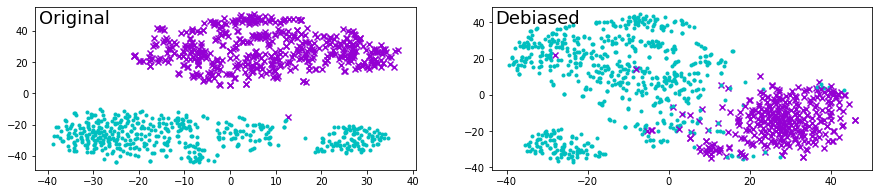

In [31]:
import operator
import random
random.seed(1)
random_state = 1

size = 500
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]

X_bef, X_aft = extract_vectors(male + female)
y_true = [0]*size + [1]*size
cluster_and_visualize(male + female, X_bef, X_aft, random_state, y_true)

C:\Users\biagi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\biagi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


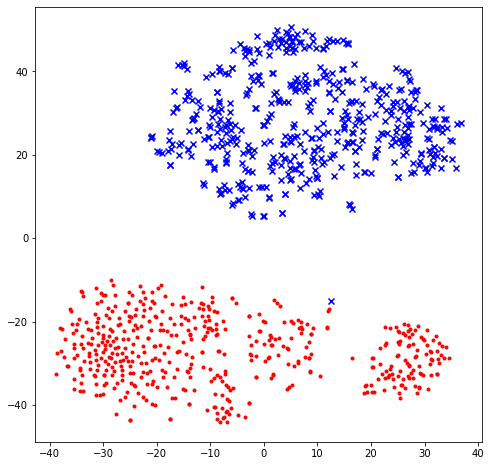

In [32]:
y_pred_bef = KMeans(n_clusters=2, random_state=random_state).fit_predict(X_bef)
X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(X_bef)
for x,l,g in zip(X_embedded, y_pred_bef, y_true):
    if l and g:
        plt.scatter(x[0], x[1], marker = ".", c='r')
    if l and not g:
        plt.scatter(x[0], x[1], marker = "x", c='r')
    if not l and g:
        plt.scatter(x[0], x[1], marker = ".", c='b')
    if not l and not g:
        plt.scatter(x[0], x[1], marker = "x", c='b')
plt.savefig('orig_clustering.png')

C:\Users\biagi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\biagi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


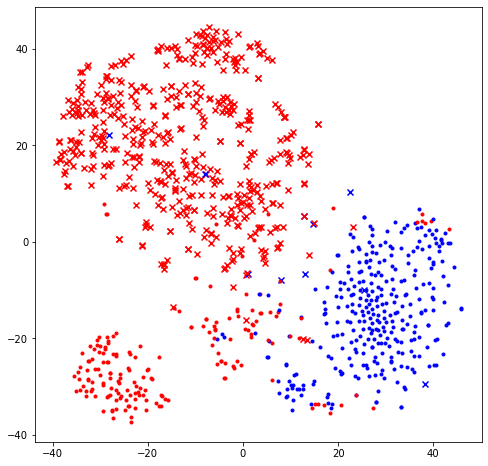

In [33]:
y_pred_aft = KMeans(n_clusters=2, random_state=random_state).fit_predict(X_aft)
X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(X_aft)
for x,l,g in zip(X_embedded, y_pred_aft, y_true):
    if l and g:
        plt.scatter(x[0], x[1], marker = ".", c='b')
    if l and not g:
        plt.scatter(x[0], x[1], marker = "x", c='b')
    if not l and g:
        plt.scatter(x[0], x[1], marker = ".", c='r')
    if not l and not g:
        plt.scatter(x[0], x[1], marker = "x", c='r')
plt.savefig('hd1_clustering.png')

### Professions experiment

### Applying the profession experiment by Gonen and Golberg but using a list of adjectives and sports

In [35]:
with open('data/lists/english-adjectives.txt') as f:
    adj = [line.strip() for line in f]

In [34]:
with open('data/lists/sports.txt') as f:
    sports = [line.strip() for line in f]
for i in range(len(sports)):
    sports[i]=sports[i].lower()

In [36]:
import json 

def extract_professions():
    professions = []
    with codecs.open('data/lists/professions.json', 'r', 'utf-8') as f:
        professions_data = json.load(f)
    for item in professions_data:
        professions.append(item[0].strip())
    return professions


professions = extract_professions()

In [37]:
import scipy.stats

def get_tuples_prof(space, words, gender_bias_dict):

    tuples = []
    for w in words:
        if w not in gender_bias_dict:
            continue
            
        top = topK(w, space, k=105)[:100]
            
        m = 0
        f = 0  
        for t in top:          
            if gender_bias_dict[t] > 0:
                m+=1
            else:
                f+=1
                
        tuples.append((w, gender_bias_bef[w], gender_bias_aft[w], m, f))
        
    return tuples

tuples_bef_prof = get_tuples_prof('limit_bef', professions, gender_bias_bef)
tuples_aft_prof = get_tuples_prof('limit_aft', professions, gender_bias_bef)

compute_corr(tuples_bef_prof, 1, 3)
compute_corr(tuples_aft_prof, 1, 3)
compute_corrS(tuples_bef_prof, 1, 3)
compute_corrS(tuples_aft_prof, 1, 3)

(0.8199919221513572, 9.223403741489439e-63)
(0.7166130605921065, 3.713908210109508e-41)
SpearmanrResult(correlation=0.788228281758878, pvalue=7.57685384193037e-55)
SpearmanrResult(correlation=0.7026079890907703, pvalue=5.766758205416694e-39)


In [39]:

tuples_bef_adj = get_tuples_prof('limit_bef', adj, gender_bias_bef)
tuples_aft_adj = get_tuples_prof('limit_aft', adj, gender_bias_bef)

compute_corr(tuples_bef_adj, 1, 3)
compute_corr(tuples_aft_adj, 1, 3)

(0.7472962474920217, 2.1512981253664409e-193)
(0.7040797299225696, 2.6460726052669546e-162)


In [38]:

tuples_bef_sports = get_tuples_prof('limit_bef', sports, gender_bias_bef)
tuples_aft_sports = get_tuples_prof('limit_aft', sports, gender_bias_bef)

compute_corr(tuples_bef_sports, 1, 3)
compute_corr(tuples_aft_sports, 1, 3)

(0.8181051629745779, 1.1630669847213752e-36)
(0.7754111653046231, 9.52472917395584e-31)


C:\Users\biagi\AppData\Local\Temp\ipykernel_7224\1065910368.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


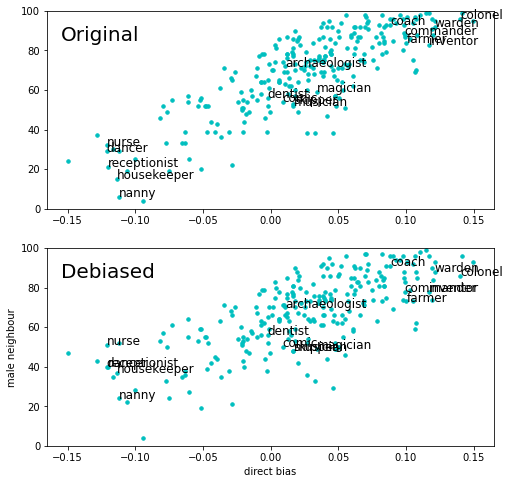

In [40]:
def show_plots(tuples_bef_prof, tuples_aft_prof):
    
    fig, axs = plt.subplots(2,1, figsize=(8,8))
    
    for i,(tuples, title) in enumerate(zip([tuples_bef_prof, tuples_aft_prof], ['Original', 'Debiased'])):
        X = []
        Y = []
        for t in tuples:
            X.append(t[1])
            Y.append(t[3])
        axs[i].scatter(X,Y, color = 'c', s=12)#plot X and Y
        axs[i].set_ylim(0,100)
        
        for t in tuples:
            if t[0] in ['nanny', 'dancer', 'housekeeper', 'receptionist', 'nurse',\
                   'magician', 'musician', 'warden', 'archaeologist', 'comic', 'dentist', \
                    'inventor', 'colonel', 'farmer', 'skipper', 'commander', 'coach']:
                axs[i].annotate(t[0], xy=(t[1], t[3]), xytext=(t[1], t[3]), textcoords="data", fontsize=12) 
        axs[i].text(.03, .85, title, transform=axs[i].transAxes, fontsize=20)
    plt.xlabel('direct bias')
    plt.ylabel('male neighbour')
    
    
    fig.show()
    fig.savefig('HD_profession', bbox_inches='tight')


show_plots(tuples_bef_prof, tuples_aft_prof)


In [260]:

def show_plot(tuples, labels, title, saveas):
    
    fig, axs = plt.subplots()   
    X = []
    Y = []
    for t in tuples:
        X.append(t[1])
        Y.append(t[3])
    axs.scatter(X,Y, color = 'c', s=12)

    for t in tuples:
        if t[0] in labels:
            axs.annotate(t[0], xy=(t[1], t[3]), xytext=(t[1], t[3]), textcoords="data", fontsize=12) 
    axs.text(.03, .85, title, transform=axs.transAxes, fontsize=20)
    plt.xlim(min(X)-0.05, max(X)+0.05)
    plt.ylim(min(Y)-5, 105)
    plt.xlabel('original direct bias',fontsize=15)
    plt.ylabel('male neighbour', fontsize=15)
    
    fig.show()
    fig.savefig(saveas, bbox_inches='tight')


<ipython-input-260-325eb0ba3b91>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


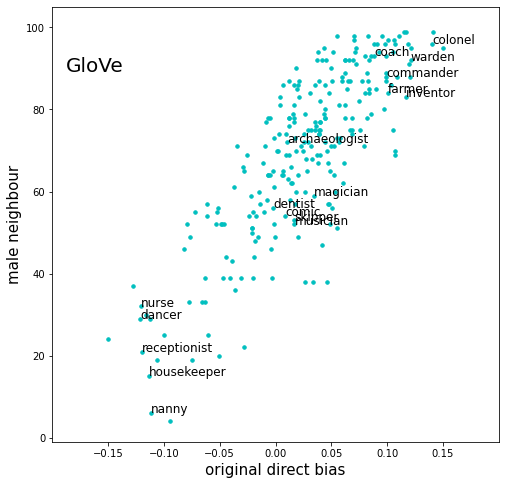

In [261]:
show_plot(tuples_bef_prof, ['nanny', 'dancer', 'housekeeper', 'receptionist', 'nurse',\
                   'magician', 'musician', 'warden', 'archaeologist', 'comic', 'dentist', \
                    'inventor', 'colonel', 'farmer', 'skipper', 'commander', 'coach'],'GloVe', 'glove_prof.png')

<ipython-input-260-325eb0ba3b91>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


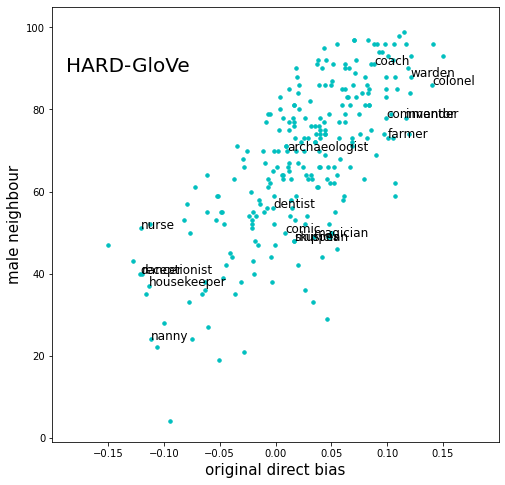

In [262]:
show_plot(tuples_aft_prof, ['nanny', 'dancer', 'housekeeper', 'receptionist', 'nurse',\
                   'magician', 'musician', 'warden', 'archaeologist', 'comic', 'dentist', \
                    'inventor', 'colonel', 'farmer', 'skipper', 'commander', 'coach'] ,'HARD-GloVe','hard_prof.png')

<ipython-input-260-325eb0ba3b91>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


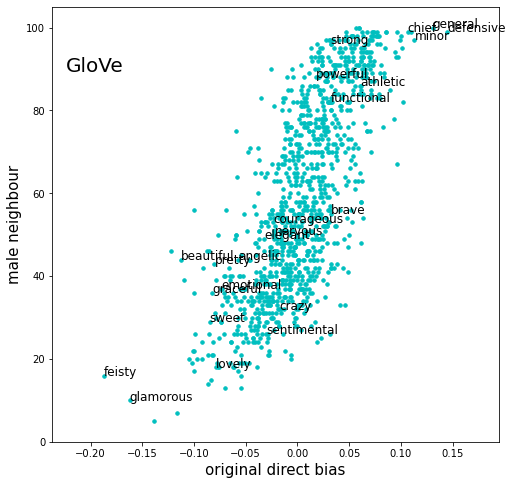

In [267]:
show_plot(tuples_bef_adj, adj1, 'GloVe', 'glove_adj.png')

<ipython-input-260-325eb0ba3b91>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


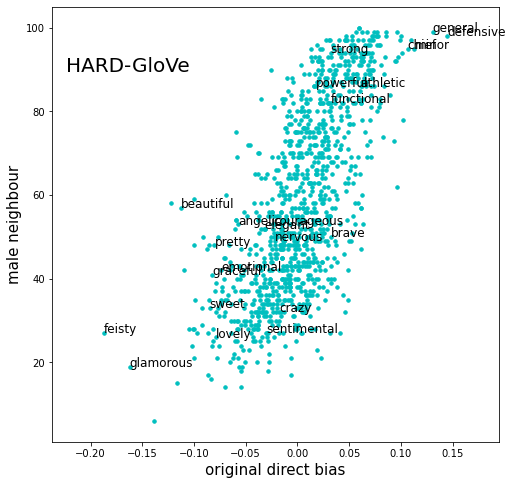

In [268]:
show_plot(tuples_aft_adj, adj1, 'HARD-GloVe', 'hard_adj.png')

<ipython-input-260-325eb0ba3b91>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


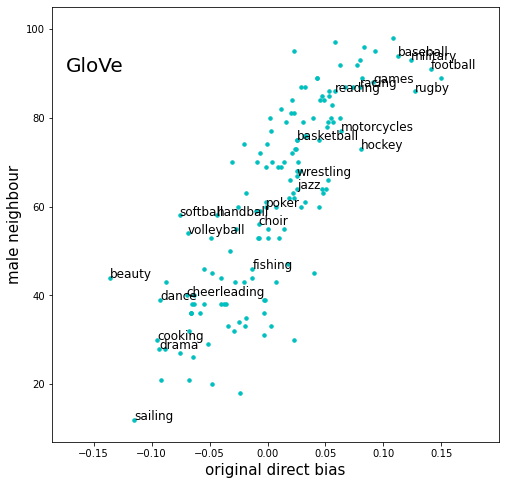

In [265]:
show_plot(tuples_bef_sports, spt1, 'GloVe', 'glove_spt.png')

<ipython-input-260-325eb0ba3b91>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


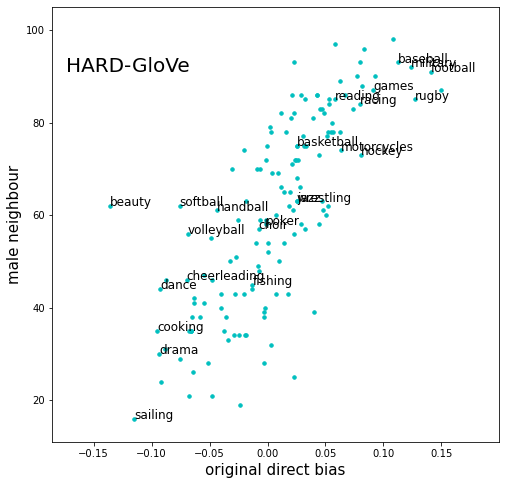

In [266]:
show_plot(tuples_aft_sports, spt1, 'HARD-GloVe', 'hard_spt.png')

In [251]:
def show_plot_col(tuples, labels, title, saveas):
      
    fig, axs = plt.subplots()
    axs = sns.scatterplot(x="orig_bias", y="male", data=tuples, hue="cat", palette={'f':'tab:olive','n': 'yellow','m':'tab:orange'})
    axs.set_ylim(0,105)
    axs.set_xlim(min(tuples['orig_bias'])-0.05, max(tuples['orig_bias'])+0.05)

    for t in range(tuples.shape[0]):
        if tuples.iloc[t,0] in labels:
            axs.annotate(tuples.iloc[t,0], xy=(tuples.iloc[t, 1], tuples.iloc[t,3]), 
                         xytext=(tuples.iloc[t, 1], tuples.iloc[t, 3]), textcoords="data", fontsize=12) 
            axs.text(.03, .75, title, transform=axs.transAxes, fontsize=20)
    plt.legend(loc = 'upper left', title = 'post direct bias')
    plt.xlabel('original direct bias', fontsize=15)
    plt.ylabel('male neighbour', fontsize=15)
    fig.show()
    fig.savefig(saveas, bbox_inches='tight')


<ipython-input-251-277f82d445cc>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


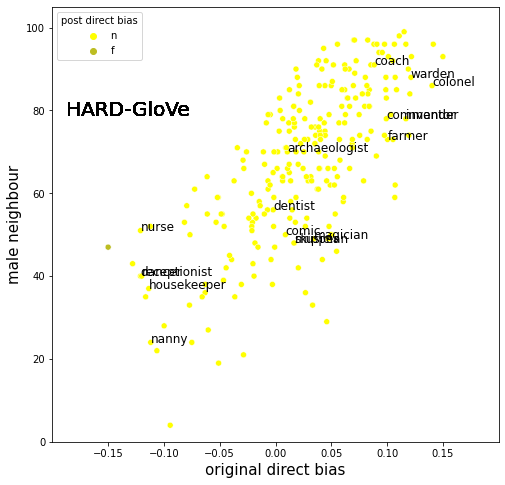

In [253]:
tap = pd.DataFrame(tuples_aft_prof, columns=['word', 'orig_bias','post_bias','male','female'])
tap['cat'] = np.where(tap.post_bias<0, 'f', 'm')
for i in range(tap.shape[0]):
    if -0.05<tap.iloc[i,2]<0.05:
        tap.iloc[i,5]='n'
show_plot_col(tap, ['nanny', 'dancer', 'housekeeper', 'receptionist', 'nurse',\
                   'magician', 'musician', 'warden', 'archaeologist', 'comic', 'dentist', \
                    'inventor', 'colonel', 'farmer', 'skipper', 'commander', 'coach'], 'HARD-GloVe', 'hard_profC')

<ipython-input-251-277f82d445cc>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


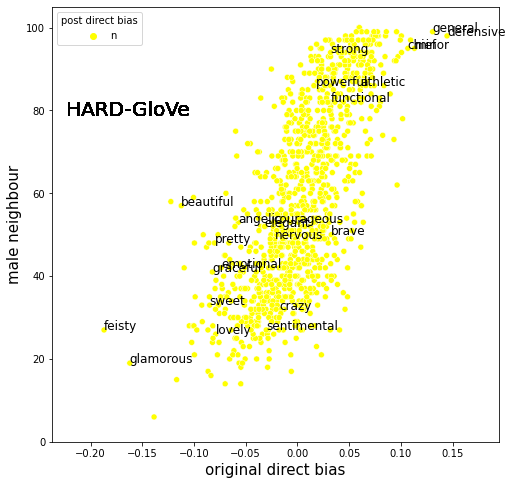

In [271]:
taa = pd.DataFrame(tuples_aft_adj, columns=['word', 'orig_bias','post_bias','male','female'])
taa['cat'] = np.where(taa.post_bias<0, 'f', 'm')
for i in range(taa.shape[0]):
    if -0.05<taa.iloc[i,2]<0.05:
        taa.iloc[i,5]='n'
show_plot_col(taa, adj1, 'HARD-GloVe', 'hard_adjC')

<ipython-input-251-277f82d445cc>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


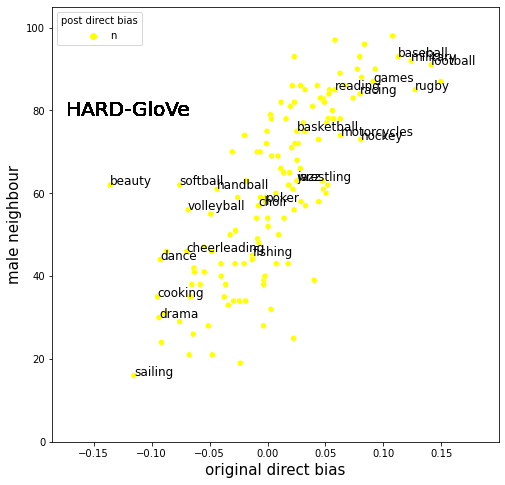

In [259]:
tas = pd.DataFrame(tuples_aft_sports, columns=['word', 'orig_bias','post_bias','male','female'])
tas['cat'] = np.where(tas.post_bias<0, 'f', 'm')
for i in range(tas.shape[0]):
    if -0.05<tas.iloc[i,2]<0.05:
        tas.iloc[i,5]='n'
show_plot_col(tas, spt1, 'HARD-GloVe', 'hard_sptC')

### Classification experiment

In [157]:

from sklearn import svm
from random import shuffle
import random
random.seed(10)



def train_and_predict(space_train, space_test):
    
    X_train = [wv[space_train][w2i[space_train][w],:] for w in males[:size_train]+females[:size_train]]
    Y_train = [1]*size_train + [0]*size_train
    X_test = [wv[space_test][w2i[space_test][w],:] for w in males[size_train:]+females[size_train:]]
    Y_test = [1]*size_test + [0]*size_test

    clf = svm.SVC(gamma='auto')
    clf.fit(X_train, Y_train)

    print('train with', space_train)
    print('test with', space_test)

    preds = clf.predict(X_test)

    accuracy = [1 if y==z else 0 for y,z in zip(preds, Y_test)]
    print('accuracy:', float(sum(accuracy))/len(accuracy))

    


size_train = 500
size_test = 2000
size = size_train + size_test
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))
females = [item[0] for item in sorted_g[:size]]
males = [item[0] for item in sorted_g[-size:]]
for f in females:
    assert(gender_bias_bef[f] < 0)
for m in males:
    assert(gender_bias_bef[m] > 0)
shuffle(females)
shuffle(males)



train_and_predict('bef', 'bef')



train_and_predict('aft', 'aft')


train with bef
test with bef
accuracy: 0.998
train with aft
test with aft
accuracy: 0.90575


### Association Experiments (Calisken et al.)

In [58]:


import scipy
import scipy.misc as misc
import itertools


def s_word(w, A, B, space, all_s_words):
    
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(similarity(w, a, space))
    for b in B:
        mean_b.append(similarity(w, b, space))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, space, all_s_words):
    
    total = 0
    for x in X:
        total += s_word(x, A, B, space, all_s_words)
    for y in Y:
        total -= s_word(y, A, B, space, all_s_words)
        
    return total


def p_value_exhust(X, Y, A, B, space):
    
    if len(X) > 10:
        print('might take too long, use sampled version: p_value')
        return
    
    assert(len(X) == len(Y))
    
    all_s_words = {}
    s_orig = s_group(X, Y, A, B, space, all_s_words) 
    
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0

    for subset in tqdm(set(itertools.combinations(union, subset_size))):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        if s_group(Xi, Yi, A, B, space, all_s_words) > s_orig:
            larger += 1
    print('num of samples', total)
    return larger/float(total)


def p_value_sample(X, Y, A, B, space):
    
    random.seed(10)
    np.random.seed(10)
    all_s_words = {}
    
    assert(len(X) == len(Y))
    length = len(X)
    
    s_orig = s_group(X, Y, A, B, space, all_s_words) 
    
    num_of_samples = min(1000000, int(scipy.special.comb(length*2,length)*100))
    print('num of samples', num_of_samples)
    larger = 0
    for i in range(num_of_samples):
        permute = np.random.permutation(X+Y)
        Xi = permute[:length]
        Yi = permute[length:]
        if s_group(Xi, Yi, A, B, space, all_s_words) > s_orig:
            larger += 1
    
    return larger/float(num_of_samples)



In [59]:

A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']
C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print(p_value_exhust(A, B, C, D, 'aft'))


E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

print(p_value_exhust(A, B, E, F, 'aft'))



G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

print(p_value_exhust(A, B, G, H, 'aft'))


  0%|                                                                                        | 0/12870 [00:00<?, ?it/s]

num of samples 12870
7.77000777000777e-05
num of samples 12870
0.2881895881895882


100%|█████████████████████████████████████████████████████████████████████████| 12870/12870 [00:00<00:00, 89868.37it/s]

num of samples 12870
0.4202020202020202


In [60]:


A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']
C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print(p_value_exhust(A, B, C, D, 'bef'))



E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

print(p_value_exhust(A, B, E, F, 'bef'))



G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

print(p_value_exhust(A, B, G, H, 'bef'))


  0%|                                                                                        | 0/12870 [00:00<?, ?it/s]

num of samples 12870
0.0
num of samples 12870
0.06775446775446775


100%|█████████████████████████████████████████████████████████████████████████| 12870/12870 [00:00<00:00, 83031.89it/s]

num of samples 12870
0.014063714063714063
